In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from skopt import BayesSearchCV

from sklearn.pipeline import Pipeline

from sklearn.metrics import plot_roc_curve

/usr/local/anaconda/lib/python3.6/site-packages/distributed/config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


In [2]:
data_loacation = '/domino/datasets/weather-dataset'

input_files = [os.path.join(data_loacation, file) for file in os.listdir(data_loacation)]

raw_data = [pd.read_csv(file) for file in input_files]
data = pd.concat(raw_data, sort=False)

display(data.head(10))
display(data.shape)
display(data.dtypes)

,ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RainTomorrow
0,1.0,Perth,15.3,21.5,4.4,2.4,1.4,NW,70.0,W,22.0,69.0,997.6,7.0,19.8,Yes,NaN
1,2.0,Portland,7.1,11.0,38.8,1.2,5.8,SSE,48.0,SW,19.0,46.0,1014.0,4.0,10.7,Yes,NaN
2,3.0,Hobart,3.6,16.6,0.2,2.8,9.3,NW,37.0,N,15.0,48.0,1016.6,5.0,15.4,No,NaN
3,4.0,Woomera,17.6,37.4,0.0,34.0,NaN,NNW,37.0,NW,19.0,11.0,1010.4,2.0,34.6,No,NaN
4,5.0,Townsville,11.4,25.6,0.0,6.0,2.8,ESE,31.0,SSE,13.0,52.0,1016.4,7.0,24.3,No,NaN
5,6.0,Nuriootpa,4.4,13.0,0.4,1.8,5.1,NW,39.0,NW,17.0,69.0,1013.6,6.0,11.3,No,NaN
6,7.0,Watsonia,12.4,22.4,0.6,3.2,4.8,SW,20.0,SSE,4.0,57.0,1020.8,3.0,21.6,No,NaN
7,8.0,Watsonia,8.3,14.1,1.0,2.4,7.1,SW,56.0,SW,22.0,58.0,1021.1,7.0,13.6,No,NaN
8,9.0,Moree,22.8,38.6,0.0,12.0,9.3,E,54.0,NNW,11.0,31.0,1001.7,6.0,37.1,No,NaN
9,10.0,Albury,18.0,26.9,0.2,NaN,NaN,NW,46.0,W,22.0,31.0,1005.2,NaN,25.9,No,NaN


(64972, 17)

ID               float64
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir           object
WindSpeed        float64
Humidity         float64
Pressure         float64
Cloud            float64
Temp             float64
RainToday         object
RainTomorrow      object
dtype: object

In [3]:
all_feature_columns = ['Location', 'MinTemp','MaxTemp','Rainfall',
                       'Evaporation','Sunshine','WindGustDir','WindGustSpeed',
                       'WindDir','WindSpeed','Humidity','Pressure','Cloud','Temp','RainToday']

all_catagorical_columns = ['Location', 'WindGustDir', 'WindDir', 'RainToday']

all_non_catagorical_columns = ['MinTemp','MaxTemp','Rainfall',
                       'Evaporation','Sunshine','WindGustSpeed',
                               'WindSpeed','Humidity','Pressure','Cloud','Temp']
label_column = 'RainTomorrow'

Location :
 count        64972
unique          49
top       Portland
freq          1648
Name: Location, dtype: object
MinTemp :
 count    64641.000000
mean        12.538918
std          6.379105
min         -8.000000
25%          7.900000
50%         12.300000
75%         17.200000
max         31.400000
Name: MinTemp, dtype: float64


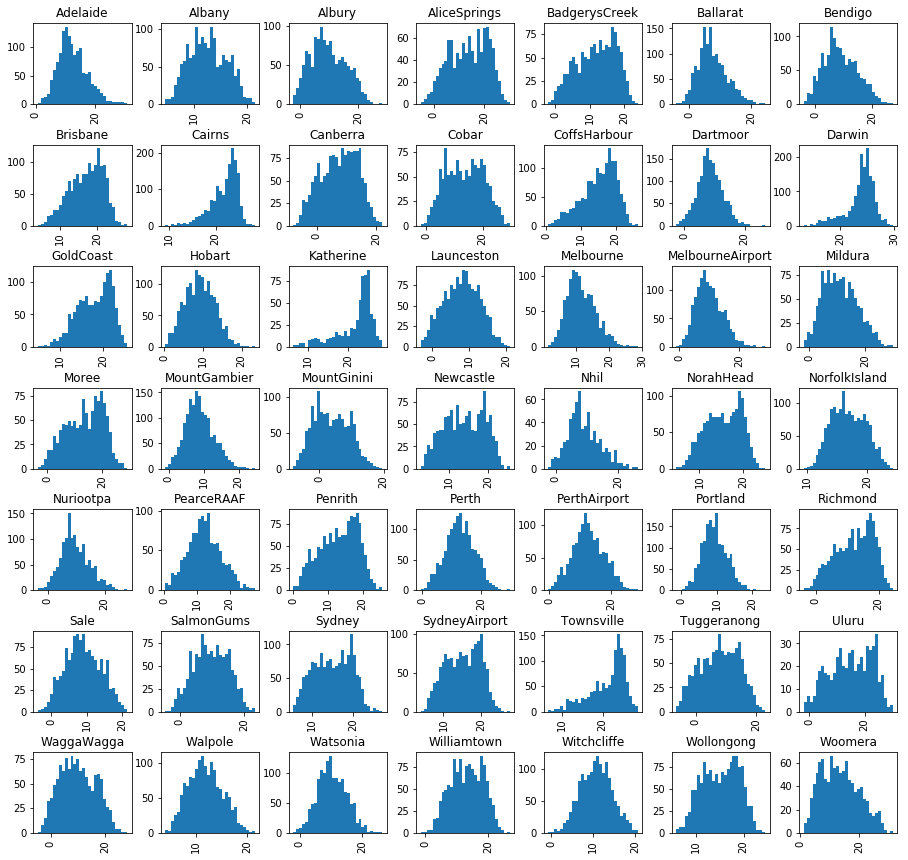

MaxTemp :
 count    64825.000000
mean        22.508492
std          7.110207
min         -4.100000
25%         17.200000
50%         21.800000
75%         27.500000
max         47.000000
Name: MaxTemp, dtype: float64


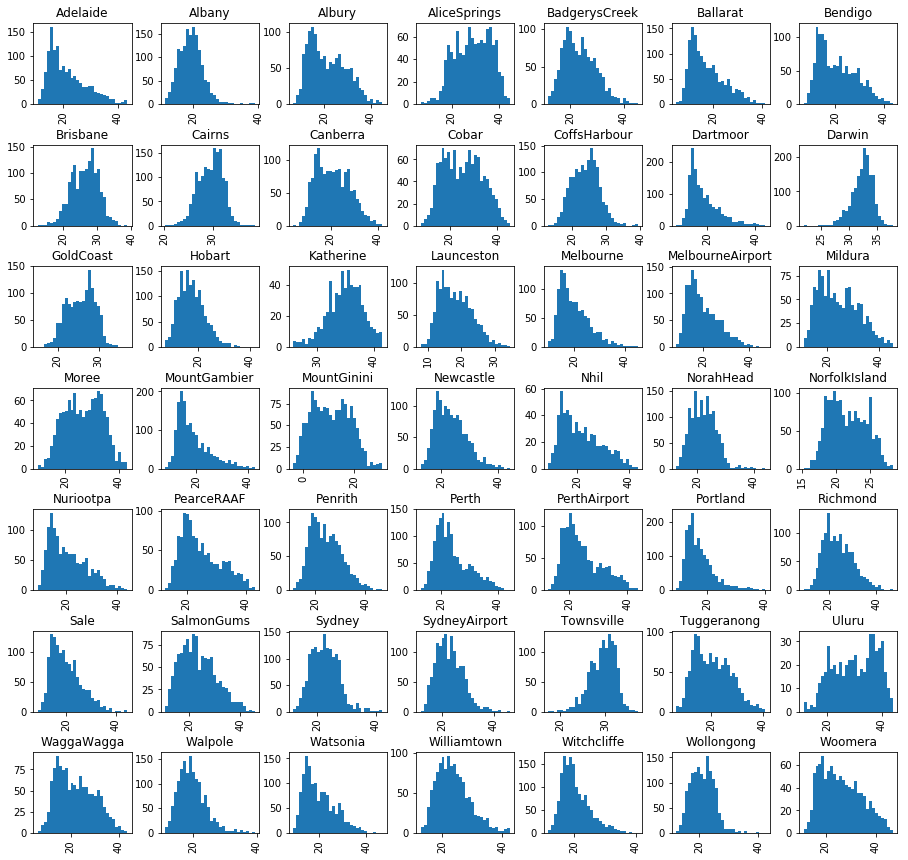

Rainfall :
 count    64064.000000
mean         3.641697
std         11.013857
min          0.000000
25%          0.000000
50%          0.000000
75%          2.200000
max        371.000000
Name: Rainfall, dtype: float64


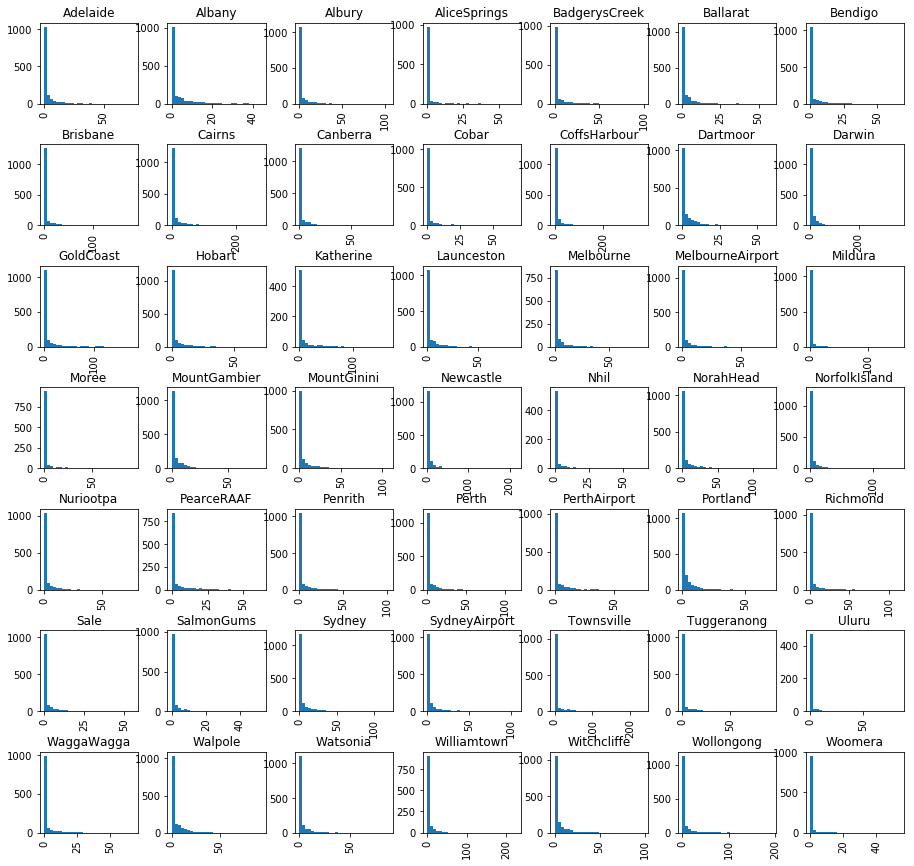

Evaporation :
 count    36903.000000
mean         5.171767
std          4.018448
min          0.000000
25%          2.400000
50%          4.400000
75%          7.000000
max         86.200000
Name: Evaporation, dtype: float64


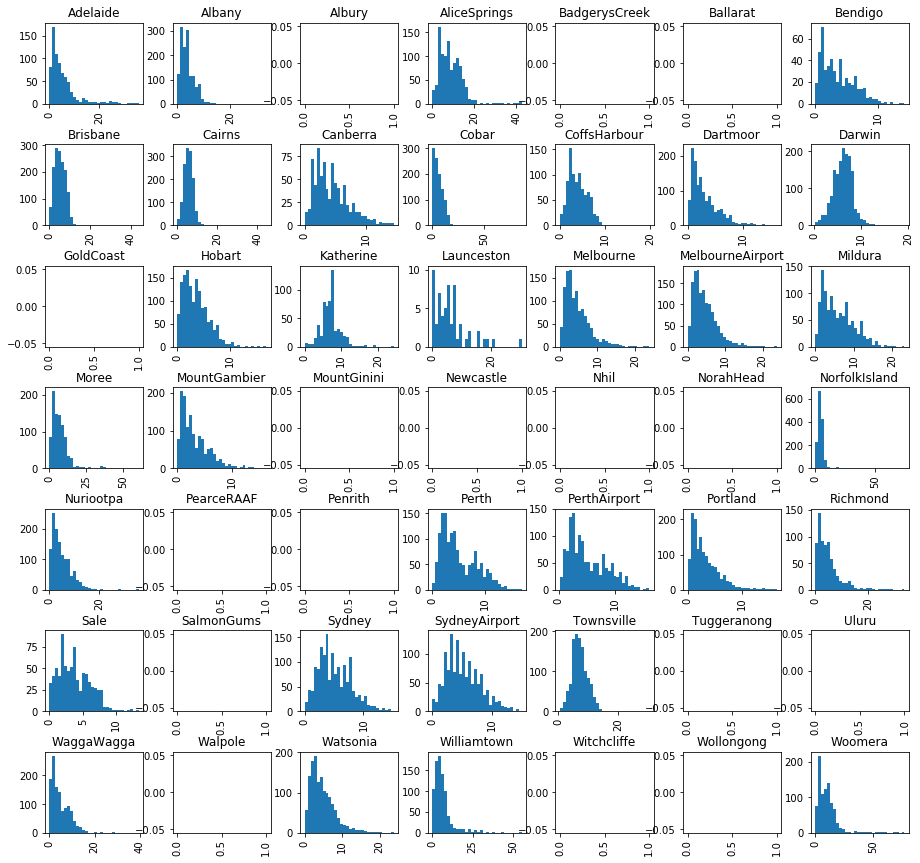

Sunshine :
 count    34003.000000
mean         6.540188
std          3.943850
min          0.000000
25%          3.200000
50%          6.900000
75%          9.900000
max         14.500000
Name: Sunshine, dtype: float64


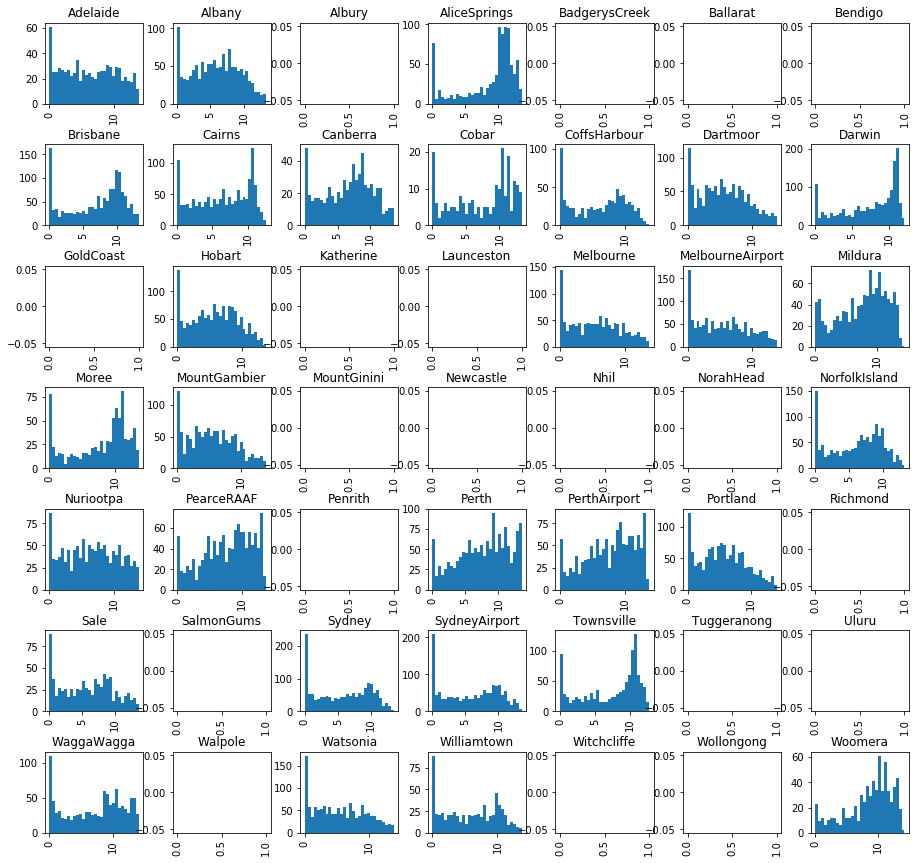

WindGustDir :
 count     60445
unique       16
top           W
freq       4720
Name: WindGustDir, dtype: object
WindGustSpeed :
 count    60481.000000
mean        42.005754
std         14.649834
min          7.000000
25%         31.000000
50%         39.000000
75%         50.000000
max        135.000000
Name: WindGustSpeed, dtype: float64


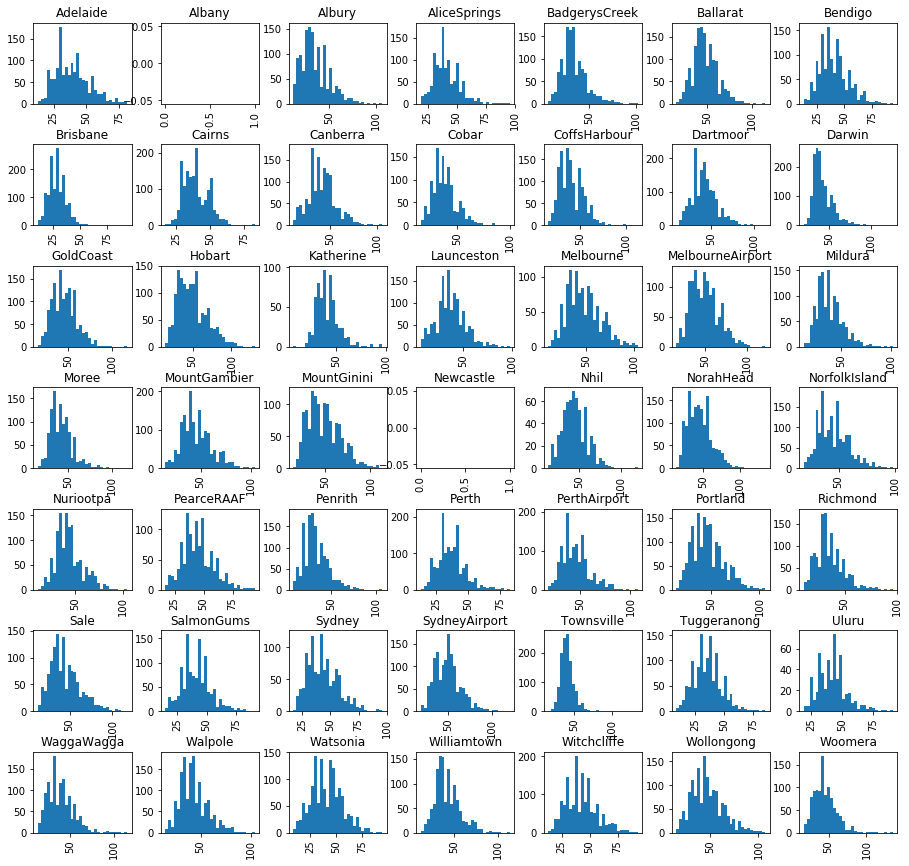

WindDir :
 count     63072
unique       16
top           W
freq       4698
Name: WindDir, dtype: object
WindSpeed :
 count    63687.000000
mean        19.089516
std          9.165967
min          0.000000
25%         13.000000
50%         19.000000
75%         24.000000
max         87.000000
Name: WindSpeed, dtype: float64


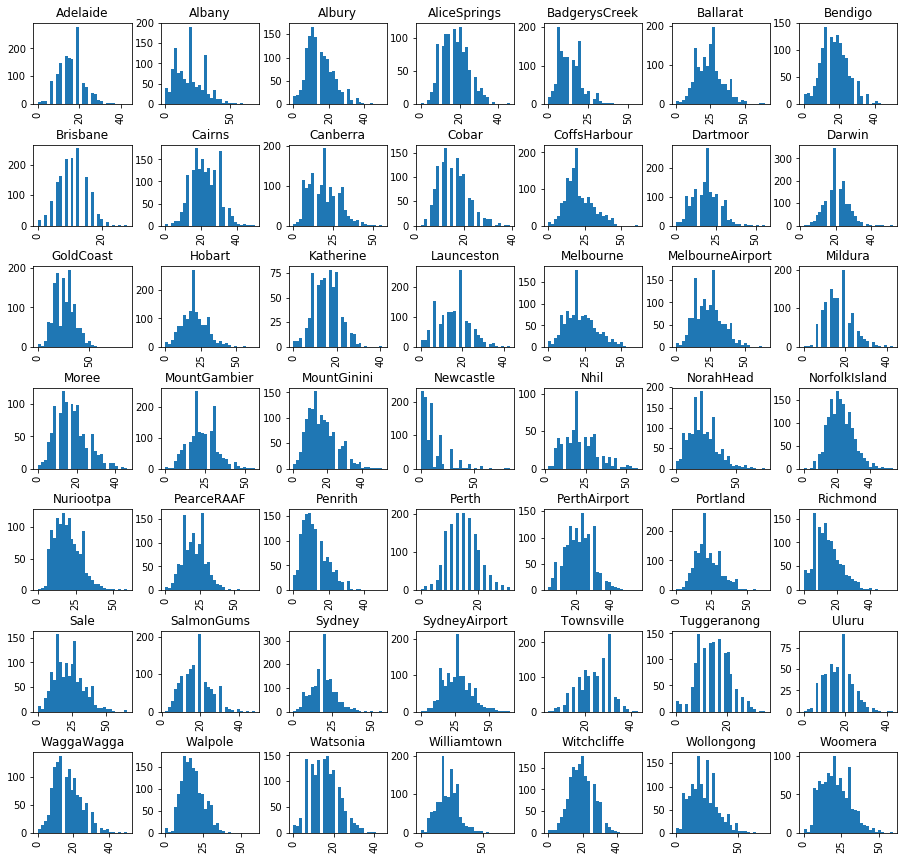

Humidity :
 count    63194.000000
mean        57.393851
std         21.837266
min          1.000000
25%         42.000000
50%         58.000000
75%         73.000000
max        100.000000
Name: Humidity, dtype: float64


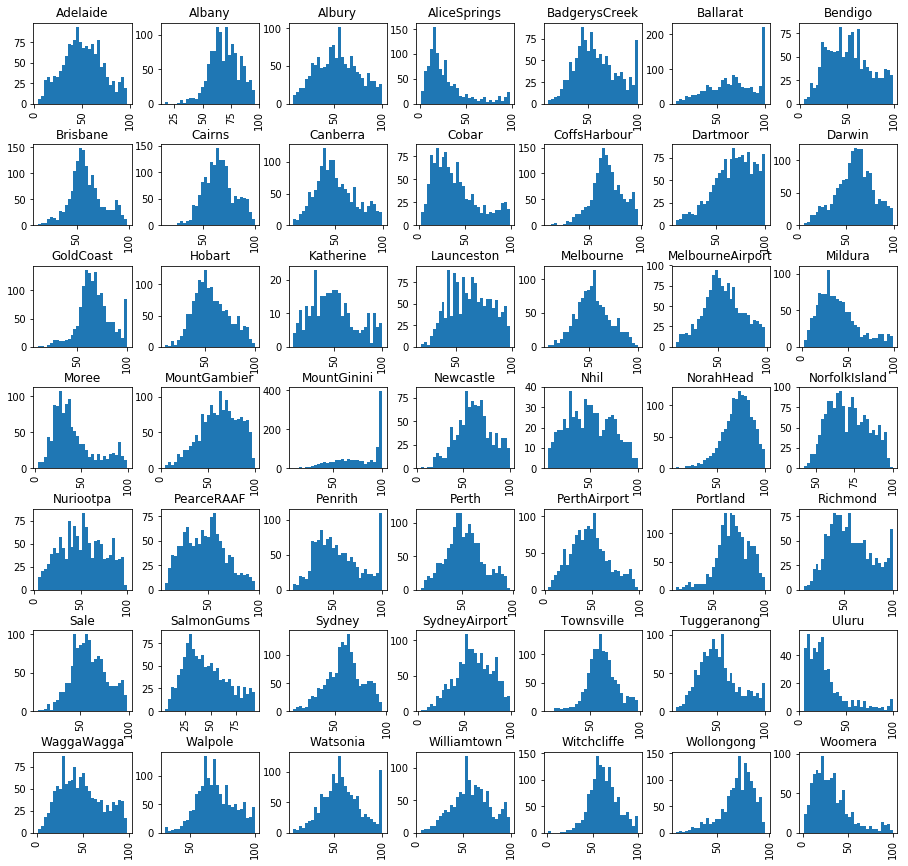

Pressure :
 count    58613.000000
mean      1014.258848
std          7.282213
min        977.100000
25%       1009.300000
50%       1014.200000
75%       1019.200000
max       1037.800000
Name: Pressure, dtype: float64


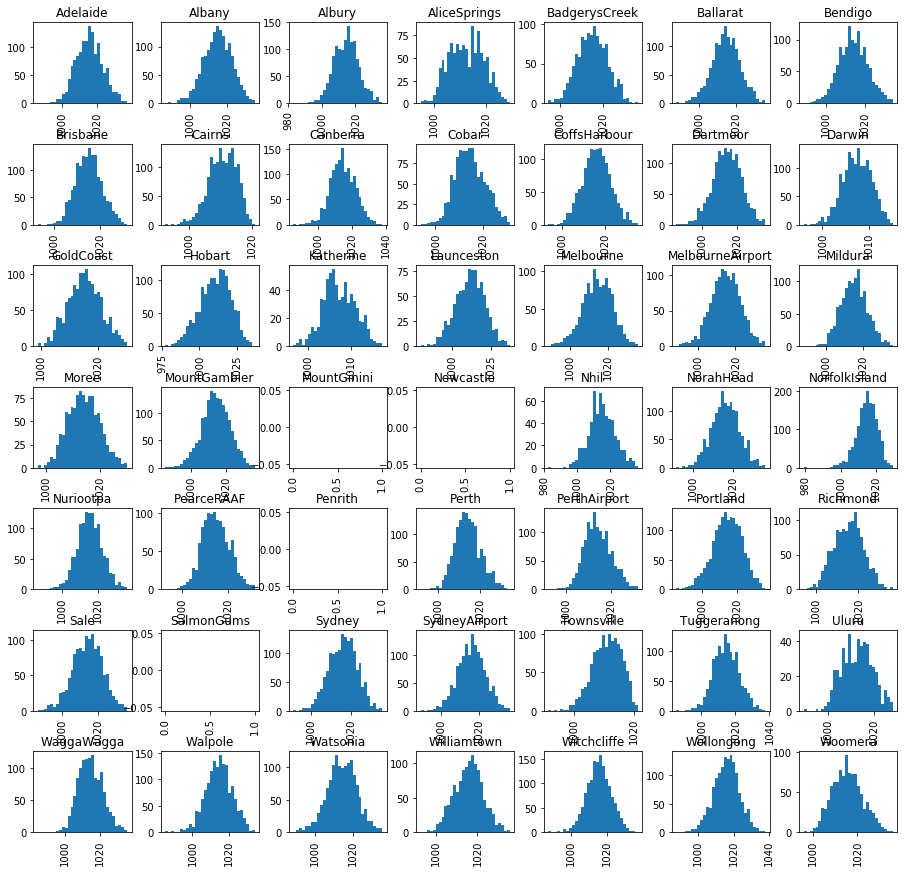

Cloud :
 count    39822.000000
mean         5.163302
std          2.634347
min          0.000000
25%          3.000000
50%          6.000000
75%          7.000000
max          8.000000
Name: Cloud, dtype: float64


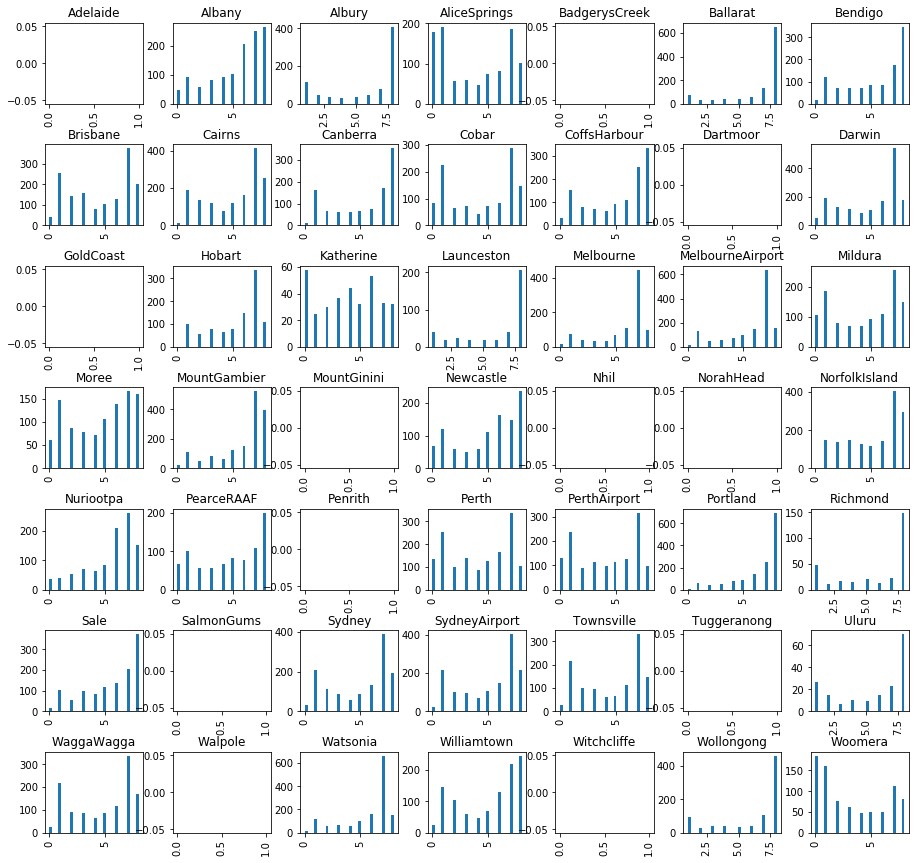

Temp :
 count    63642.000000
mean        20.841540
std          6.935772
min         -4.400000
25%         15.700000
50%         20.200000
75%         25.600000
max         46.200000
Name: Temp, dtype: float64


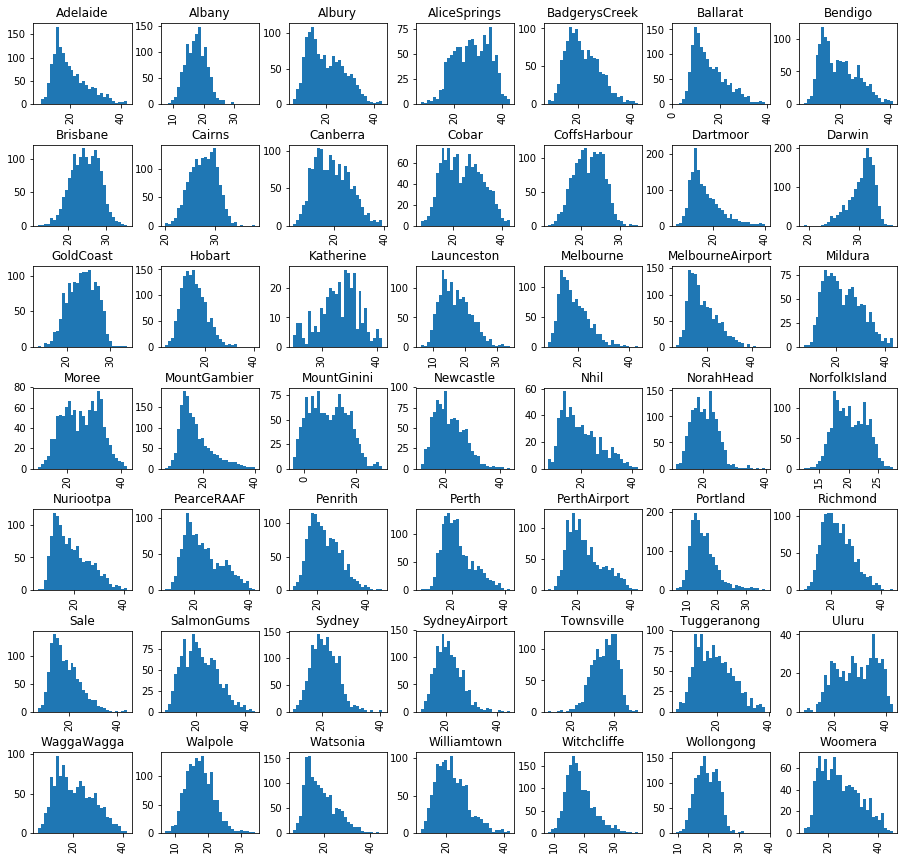

RainToday :
 count     64064
unique        2
top          No
freq      44447
Name: RainToday, dtype: object
RainTomorrow :
 count     51978
unique        2
top          No
freq      26459
Name: RainTomorrow, dtype: object


In [4]:
for c in data.columns:
    if c != 'ID':
        print(c, ':\n', data[c].describe())
        if c in  all_non_catagorical_columns:
            hist = data[[c, 'Location']].hist(by='Location', bins=30, figsize=(15,15))
            plt.show()
            pass
        print('===============================')

In [5]:
print('Null Values by Columns:\n', data.isnull().sum())

Null Values by Columns:
 ID               51978
Location             0
MinTemp            331
MaxTemp            147
Rainfall           908
Evaporation      28069
Sunshine         30969
WindGustDir       4527
WindGustSpeed     4491
WindDir           1900
WindSpeed         1285
Humidity          1778
Pressure          6359
Cloud            25150
Temp              1330
RainToday          908
RainTomorrow     12994
dtype: int64


In [6]:
print('RainToday: ',  data['RainToday'].unique())
print('RainTomorrow: ',  data['RainTomorrow'].unique())

RainToday:  ['Yes' 'No' nan]
RainTomorrow:  [nan 'Yes' 'No']


In [7]:
data.dropna(inplace=True, subset=all_catagorical_columns + [label_column])

display(data.head(10))
display(data.shape)
display(data.dtypes)

,ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RainTomorrow
0,NaN,NorahHead,18.9,23.7,0.0,NaN,NaN,SSE,41.0,SSE,28.0,55.0,1026.0,NaN,22.4,No,Yes
1,NaN,Nuriootpa,11.1,20.8,0.0,4.8,8.3,W,39.0,WSW,26.0,48.0,1014.4,7.0,19.5,No,No
2,NaN,GoldCoast,15.9,19.5,17.6,NaN,NaN,SE,44.0,SW,9.0,99.0,1028.5,NaN,17.8,Yes,Yes
3,NaN,Bendigo,0.0,14.9,0.0,NaN,NaN,WSW,35.0,WNW,19.0,55.0,1023.0,4.0,14.2,No,Yes
4,NaN,Walpole,9.1,22.7,0.0,NaN,NaN,NNE,41.0,ESE,7.0,40.0,1027.1,NaN,22.5,No,No
5,NaN,MelbourneAirport,6.6,16.3,8.4,3.4,6.9,S,50.0,S,30.0,55.0,1021.4,7.0,14.6,Yes,No
6,NaN,Mildura,9.7,20.6,0.0,1.0,4.2,WNW,61.0,NW,20.0,35.0,1015.8,7.0,19.5,No,No
7,NaN,Williamtown,17.1,21.9,134.8,NaN,0.0,SSE,54.0,SSE,28.0,99.0,1012.0,8.0,17.9,Yes,Yes
8,NaN,Watsonia,13.5,23.5,0.0,6.8,6.5,NW,46.0,NE,19.0,53.0,1018.2,6.0,22.2,No,Yes
9,NaN,Nhil,12.5,21.3,0.0,NaN,NaN,W,65.0,W,22.0,82.0,1002.6,NaN,13.1,No,Yes


(47345, 17)

ID               float64
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir           object
WindSpeed        float64
Humidity         float64
Pressure         float64
Cloud            float64
Temp             float64
RainToday         object
RainTomorrow      object
dtype: object

In [8]:
print('Null Values by Columns:\n', data.isnull().sum())

Null Values by Columns:
 ID               47345
Location             0
MinTemp             45
MaxTemp             16
Rainfall             0
Evaporation      20068
Sunshine         22260
WindGustDir          0
WindGustSpeed        0
WindDir              0
WindSpeed            0
Humidity           636
Pressure          3460
Cloud            18361
Temp               307
RainToday            0
RainTomorrow         0
dtype: int64


In [9]:
display(data.head(10))

,ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RainTomorrow
0,NaN,NorahHead,18.9,23.7,0.0,NaN,NaN,SSE,41.0,SSE,28.0,55.0,1026.0,NaN,22.4,No,Yes
1,NaN,Nuriootpa,11.1,20.8,0.0,4.8,8.3,W,39.0,WSW,26.0,48.0,1014.4,7.0,19.5,No,No
2,NaN,GoldCoast,15.9,19.5,17.6,NaN,NaN,SE,44.0,SW,9.0,99.0,1028.5,NaN,17.8,Yes,Yes
3,NaN,Bendigo,0.0,14.9,0.0,NaN,NaN,WSW,35.0,WNW,19.0,55.0,1023.0,4.0,14.2,No,Yes
4,NaN,Walpole,9.1,22.7,0.0,NaN,NaN,NNE,41.0,ESE,7.0,40.0,1027.1,NaN,22.5,No,No
5,NaN,MelbourneAirport,6.6,16.3,8.4,3.4,6.9,S,50.0,S,30.0,55.0,1021.4,7.0,14.6,Yes,No
6,NaN,Mildura,9.7,20.6,0.0,1.0,4.2,WNW,61.0,NW,20.0,35.0,1015.8,7.0,19.5,No,No
7,NaN,Williamtown,17.1,21.9,134.8,NaN,0.0,SSE,54.0,SSE,28.0,99.0,1012.0,8.0,17.9,Yes,Yes
8,NaN,Watsonia,13.5,23.5,0.0,6.8,6.5,NW,46.0,NE,19.0,53.0,1018.2,6.0,22.2,No,Yes
9,NaN,Nhil,12.5,21.3,0.0,NaN,NaN,W,65.0,W,22.0,82.0,1002.6,NaN,13.1,No,Yes


In [10]:
feature_df = data[all_feature_columns]
labels_df = data[[label_column]]
display(feature_df.head(10))
display(labels_df.head(10))

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday
0,NorahHead,18.9,23.7,0.0,NaN,NaN,SSE,41.0,SSE,28.0,55.0,1026.0,NaN,22.4,No
1,Nuriootpa,11.1,20.8,0.0,4.8,8.3,W,39.0,WSW,26.0,48.0,1014.4,7.0,19.5,No
2,GoldCoast,15.9,19.5,17.6,NaN,NaN,SE,44.0,SW,9.0,99.0,1028.5,NaN,17.8,Yes
3,Bendigo,0.0,14.9,0.0,NaN,NaN,WSW,35.0,WNW,19.0,55.0,1023.0,4.0,14.2,No
4,Walpole,9.1,22.7,0.0,NaN,NaN,NNE,41.0,ESE,7.0,40.0,1027.1,NaN,22.5,No
5,MelbourneAirport,6.6,16.3,8.4,3.4,6.9,S,50.0,S,30.0,55.0,1021.4,7.0,14.6,Yes
6,Mildura,9.7,20.6,0.0,1.0,4.2,WNW,61.0,NW,20.0,35.0,1015.8,7.0,19.5,No
7,Williamtown,17.1,21.9,134.8,NaN,0.0,SSE,54.0,SSE,28.0,99.0,1012.0,8.0,17.9,Yes
8,Watsonia,13.5,23.5,0.0,6.8,6.5,NW,46.0,NE,19.0,53.0,1018.2,6.0,22.2,No
9,Nhil,12.5,21.3,0.0,NaN,NaN,W,65.0,W,22.0,82.0,1002.6,NaN,13.1,No


,RainTomorrow
0,Yes
1,No
2,Yes
3,Yes
4,No
5,No
6,No
7,Yes
8,Yes
9,Yes


In [11]:
display(feature_df[all_catagorical_columns].head(10))
display(feature_df[all_non_catagorical_columns].head(10))

,Location,WindGustDir,WindDir,RainToday
0,NorahHead,SSE,SSE,No
1,Nuriootpa,W,WSW,No
2,GoldCoast,SE,SW,Yes
3,Bendigo,WSW,WNW,No
4,Walpole,NNE,ESE,No
5,MelbourneAirport,S,S,Yes
6,Mildura,WNW,NW,No
7,Williamtown,SSE,SSE,Yes
8,Watsonia,NW,NE,No
9,Nhil,W,W,No


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed,Humidity,Pressure,Cloud,Temp
0,18.9,23.7,0.0,NaN,NaN,41.0,28.0,55.0,1026.0,NaN,22.4
1,11.1,20.8,0.0,4.8,8.3,39.0,26.0,48.0,1014.4,7.0,19.5
2,15.9,19.5,17.6,NaN,NaN,44.0,9.0,99.0,1028.5,NaN,17.8
3,0.0,14.9,0.0,NaN,NaN,35.0,19.0,55.0,1023.0,4.0,14.2
4,9.1,22.7,0.0,NaN,NaN,41.0,7.0,40.0,1027.1,NaN,22.5
5,6.6,16.3,8.4,3.4,6.9,50.0,30.0,55.0,1021.4,7.0,14.6
6,9.7,20.6,0.0,1.0,4.2,61.0,20.0,35.0,1015.8,7.0,19.5
7,17.1,21.9,134.8,NaN,0.0,54.0,28.0,99.0,1012.0,8.0,17.9
8,13.5,23.5,0.0,6.8,6.5,46.0,19.0,53.0,1018.2,6.0,22.2
9,12.5,21.3,0.0,NaN,NaN,65.0,22.0,82.0,1002.6,NaN,13.1


In [12]:
vocabulary = {cat: feature_df[cat].unique().tolist() for cat in all_catagorical_columns}
vocabulary_list = list(vocabulary.values())
print(vocabulary_list)

[['NorahHead', 'Nuriootpa', 'GoldCoast', 'Bendigo', 'Walpole', 'MelbourneAirport', 'Mildura', 'Williamtown', 'Watsonia', 'Nhil', 'MountGinini', 'BadgerysCreek', 'SydneyAirport', 'Tuggeranong', 'WaggaWagga', 'Hobart', 'Portland', 'AliceSprings', 'Brisbane', 'PerthAirport', 'Witchcliffe', 'Darwin', 'Ballarat', 'Canberra', 'MountGambier', 'Penrith', 'Townsville', 'Cairns', 'Cobar', 'PearceRAAF', 'NorfolkIsland', 'Launceston', 'Woomera', 'Adelaide', 'Albury', 'Dartmoor', 'SalmonGums', 'Richmond', 'Melbourne', 'Sydney', 'CoffsHarbour', 'Perth', 'Wollongong', 'Uluru', 'Moree', 'Sale', 'Katherine'], ['SSE', 'W', 'SE', 'WSW', 'NNE', 'S', 'WNW', 'NW', 'ENE', 'NNW', 'SW', 'SSW', 'E', 'N', 'NE', 'ESE'], ['SSE', 'WSW', 'SW', 'WNW', 'ESE', 'S', 'NW', 'NE', 'W', 'NNE', 'NNW', 'N', 'SSW', 'SE', 'E', 'ENE'], ['No', 'Yes']]


In [13]:
preprocessor = ColumnTransformer(
        [
            ('fs', FunctionTransformer(), all_non_catagorical_columns),
            ("cat", OneHotEncoder(categories=vocabulary_list, drop='first', sparse=False), all_catagorical_columns)
        ])

preprocessor.fit_transform(feature_df)

array([[18.9, 23.7,  0. , ...,  0. ,  0. ,  0. ],
       [11.1, 20.8,  0. , ...,  0. ,  0. ,  0. ],
       [15.9, 19.5, 17.6, ...,  0. ,  0. ,  1. ],
       ...,
       [14.2, 18.6,  2.8, ...,  0. ,  0. ,  1. ],
       [11.1, 17.2,  1.2, ...,  0. ,  0. ,  1. ],
       [21.6, 36.2,  0. , ...,  0. ,  1. ,  0. ]])

In [14]:
labels = labels_df.apply(lambda row: 1 if row['RainTomorrow'] == 'Yes' else 0, axis=1)
print(labels)

0        1
1        0
2        1
3        1
4        0
5        0
6        0
7        1
8        1
9        1
10       0
11       1
13       1
14       1
15       0
16       1
17       1
18       1
19       0
20       1
21       0
22       0
23       1
24       0
25       1
27       1
28       0
29       1
30       0
31       1
        ..
51945    0
51946    0
51947    1
51948    1
51949    1
51950    1
51951    0
51952    1
51953    0
51955    1
51957    1
51958    1
51959    0
51960    0
51961    0
51962    0
51963    1
51964    0
51965    1
51966    0
51967    0
51968    1
51969    1
51970    1
51971    0
51972    0
51973    1
51974    1
51975    1
51977    0
Length: 47345, dtype: int64


In [15]:
X_train, X_test, y_train, y_test = train_test_split(feature_df, labels, test_size=0.20, random_state=42)
display(X_train.head())
display(X_test.head())

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday
50702,GoldCoast,16.2,24.0,0.0,NaN,NaN,NW,26.0,NW,17.0,49.0,1021.7,NaN,23.1,No
21222,CoffsHarbour,19.1,25.7,0.2,5.0,5.8,ESE,43.0,E,17.0,75.0,1017.6,8.0,23.6,No
5922,AliceSprings,7.8,25.3,0.0,7.2,10.0,ESE,31.0,SE,15.0,6.0,1017.1,2.0,24.9,No
48575,Sale,10.7,18.2,8.8,NaN,NaN,W,80.0,W,35.0,60.0,1005.4,8.0,15.7,Yes
22799,Launceston,15.1,22.1,0.0,NaN,NaN,S,39.0,NW,13.0,46.0,NaN,4.0,19.5,No


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday
16067,Witchcliffe,11.6,19.6,24.0,NaN,NaN,S,54.0,S,26.0,54.0,1014.4,NaN,16.1,Yes
22459,Ballarat,16.1,29.2,0.0,NaN,NaN,NNE,37.0,SSW,4.0,22.0,1019.5,7.0,27.9,No
4891,SalmonGums,10.2,16.6,9.4,NaN,NaN,NE,33.0,N,7.0,83.0,NaN,NaN,15.8,Yes
1843,SalmonGums,5.3,27.5,0.0,NaN,NaN,S,37.0,SE,20.0,27.0,NaN,NaN,26.0,No
50254,Portland,10.1,14.0,15.8,6.0,7.1,W,63.0,W,35.0,64.0,1008.6,8.0,13.0,Yes


In [16]:
tuner = BayesSearchCV(
estimator = XGBClassifier(objective='binary:logistic', eval_metric='auc', verbose=True),
    search_spaces = {
        'learning_rate': (0.01, 0.5, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (5, 100),
        'scale_pos_weight': (1, 50, 'log-uniform')
    },    
    scoring = 'roc_auc',
    
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = 15,   
    verbose = 0,
    refit = True,
    random_state = 42
)

In [33]:
# executes bayesian optimization
_ = tuner.fit(preprocessor.fit_transform(X_train), y_train)

In [18]:
# model can be saved, used for predictions or scoring
print(tuner.score(preprocessor.fit_transform(X_test), y_test))

0.8923934225796626


In [19]:
tuner.best_estimator_

XGBClassifier(base_score=0.5, booster=None,
              colsample_bylevel=0.5479690370134094, colsample_bynode=1,
              colsample_bytree=0.9208091341729433, eval_metric='auc', gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.0697400151786318, max_delta_step=17, max_depth=16,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=59, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=2, subsample=0.39187229507481813,
              tree_method=None, validate_parameters=False, verbose=True,
              verbosity=None)

In [36]:
pipeline = Pipeline(steps=[('transformer', preprocessor),
                      ('classifier', tuner.best_estimator_)], verbose=True)

In [37]:
pipeline.fit(X_train, y_train)

[Pipeline] ....... (step 1 of 2) Processing transformer, total=   0.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  42.0s


Pipeline(memory=None,
         steps=[('transformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('fs',
                                                  FunctionTransformer(accept_sparse=False,
                                                                      check_inverse=True,
                                                                      func=None,
                                                                      inv_kw_args=None,
                                                                      inverse_func=None,
                                                                      kw_args=None,
                                                                      validate=False),
                                                  ['MinTemp', 'MaxTemp',
                       

In [38]:
print('Train Scor:', pipeline.score(X_train, y_train))
print('Test Scor:', pipeline.score(X_test, y_test))

Train Scor: 0.9230647375646848
Test Scor: 0.8011405639455064


In [39]:
small_feature_columns = ['Rainfall', 'Humidity','Pressure','Cloud']

In [40]:
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(feature_df[small_feature_columns], labels, test_size=0.20, random_state=42)
display(X_train_sf.head())
display(X_test_sf.head())

,Rainfall,Humidity,Pressure,Cloud
50702,0.0,49.0,1021.7,NaN
21222,0.2,75.0,1017.6,8.0
5922,0.0,6.0,1017.1,2.0
48575,8.8,60.0,1005.4,8.0
22799,0.0,46.0,NaN,4.0


,Rainfall,Humidity,Pressure,Cloud
16067,24.0,54.0,1014.4,NaN
22459,0.0,22.0,1019.5,7.0
4891,9.4,83.0,NaN,NaN
1843,0.0,27.0,NaN,NaN
50254,15.8,64.0,1008.6,8.0


In [41]:
opt = BayesSearchCV(
estimator = XGBClassifier(objective='binary:logistic', eval_metric='auc', verbose=True),
    search_spaces = {
        'learning_rate': (0.01, 0.5, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (5, 100),
        'scale_pos_weight': (1, 50, 'log-uniform')
    },    
    scoring = 'roc_auc',
    
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = 15,   
    verbose = 0,
    refit = True,
    random_state = 42
)

In [42]:
# executes bayesian optimization
_ = opt.fit(X_train_sf, y_train_sf)

In [43]:
xgb_clf = opt.best_estimator_

In [44]:
print('Train Scor:', xgb_clf.score(X_train_sf, y_train_sf))
print('Test Scor:', xgb_clf.score(X_test_sf, y_test_sf))

Train Scor: 0.7908174041609463
Test Scor: 0.7546731439433942


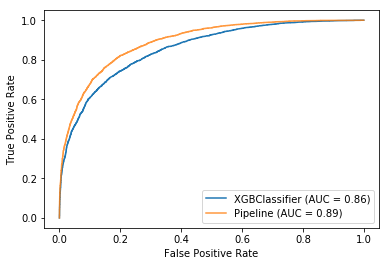

In [45]:
xgb_disp = plot_roc_curve(xgb_clf, X_test_sf, y_test_sf)
ax = plt.gca()
pl_disp = plot_roc_curve(pipeline, X_test, y_test, ax=ax, alpha=0.8)
plt.show()